In [1]:
from General import functies as functies
from General import classes as classes
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

In [2]:
#code geript van de geluidsproef
def X_tractor(inhoud, previous = None): #extraheert effectief nuttige data uit die txt-files


    #bepaal de initiële values van de fit (met de headerdata)
    amplitude = float(inhoud.split("PK-PK                :		")[1][:4])/2 #de helft van de peak-to-peak +20 om te kleine fits te breken

    gesplit = inhoud.split('Time interval        :		')

    #bepaal de stapbreedte
    getal = ""
    eenheid = ""
    count = 0
    punt_gevonden = False
    for digit in gesplit[1]:
        if digit.isdigit():
            getal += digit
        elif digit == '.' and not punt_gevonden:
            getal += digit
            punt_gevonden = True
        else:
            eenheid+=digit
            count+=1
        if count == 2:
            break
    getal = float(getal)
    #fix de SI prefix van de stapbreedte
    if eenheid == "us": #bro een u voor µ deze oscilloscoop is ass
        stapbreedte = getal *10**(-6)
    elif eenheid == "ms":
        stapbreedte = getal * 10**(-3)
    else:
        raise ChildProcessError("children have defined units of " + eenheid)
    #haal de twee kolommen uit de txt-file en transponeer ze
    tabel = gesplit[1].split('index		CH1_Voltage(mV)\n')[1]
    nuttigtransponent = [X.split('		') for X in tabel.split('\n')][:-1] #skip het laatste element want dat is leeg (een enter op het einde van de txt)
    nuttig = [[float(nuttigtransponent[j][i]) for j in range(len(nuttigtransponent))] for i in range(len(nuttigtransponent[0]))]
    #fix de verder gebruikte arrays in analyse
    T = np.array(nuttig[0])*stapbreedte
    T = T - T[0] #gezien het toch periodisch is kunnen we het laten starten bij nul
    Vpart = np.array(nuttig[1])        
    
    C = (np.max(Vpart)+np.min(Vpart))/2 #zou ook moeten werken i guess
    

    
    invals = [amplitude, C] #Was eerder 4*pi*freq, maar omega=2pif, dus idk wat het plan was
    #Eenheden zijn enorm cooked, 10^-5 factor moet nog bij freq om shit te doen kloppen, zie twee code blokken verder, hier wat getest (werkte op oude code)
    return T, Vpart, eenheid, invals

def uncook_data(Tpart, Vpart, V_part_fout):

    Tnew = []
    Vnew = []
    Verrnew = []
    indx = 0
    while indx < len(Tpart)-1:
        indx2 = indx
        while indx2 < len(Tpart)-1 and Tpart[indx] == Tpart[indx2]:
            indx2 += 1
        
        tijd = np.mean(np.array([Tpart[ind] for ind in range(indx, indx2)]))
        spanning = Vpart[indx]
        fout = np.sqrt(indx2 - indx)*V_part_fout[indx]
        Tnew.append(tijd)
        Vnew.append(spanning)
        Verrnew.append(fout)
        indx = indx2
    Tnew = np.array(Tnew)
    Vnew = np.array(Vnew)
    Verrnew = np.array(Verrnew)
    assert np.shape(Verrnew) == np.shape(Vnew)
    return Tnew, Vnew, Verrnew

#das Model des Elektrofelds
def model_E(Zeit, Festeparameters, Fitparameters):
    Kordelänge, model = Festeparameters
    phase, amplitude, Ruhe, omega, q, x0 = Fitparameters
    epsilon_nul = 8.85e-12

    if model == '1D quasistatic':
        epsilon_nul = 8.85e-12
        Abstand = x0 + amplitude * np.sin(omega*Zeit + phase)
        E = q/(4*np.pi*epsilon_nul) * (1/Abstand)**2 + Ruhe

    elif model == 'sinus':
        #voor de meme testen of een sinus werkt #spoiler: nee
        return amplitude * np.sin(omega*Zeit + phase) + x0
    
    elif model == '2D quasistatic':
        #quasistatisch, 2D-versie (met sin(x) = x-approc van de slinger)
        theta_max = np.arcsin(amplitude/Kordelänge)
        #print('theta_max in graden', theta_max*180/np.pi)
        theta = theta_max * np.sin(omega*Zeit + phase)
        AbstandKwadrat = (x0+Kordelänge*np.sin(theta))**2+Kordelänge**2*np.cos(theta)**2

        C = Ruhe #- np.average(q/(4*np.pi*epsilon_nul) * (1/np.linspace(0,1000,100000)**2)) #remove the average bias
        E = q/(4*np.pi*epsilon_nul) * (1/AbstandKwadrat)**(3/2) * (x0 + Kordelänge*np.sin(theta)) + C

    return E

3.8553386833890952 omega_inval
C_0 by fft -1432.92578125
5


c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


[[-3.1415758546059593, -3.1694372180450463], [0.07913989035540375, 0.07923814702230388], [-489.89084136759516, -490.02568714008106], [3.0211904797893783, 4.580837040330568], [9.998505719982479e-09, 1.0001491706736924e-08], [0.518422167103993, 0.5184949412203239]]
phi heeft als waarde: -3.1416 + -0.027845 - -1.6799e-05 met 68% betrouwbaarheidsinterval: [-3.1416, -3.1694] 
A heeft als waarde: 0.079189 + 4.9111e-05 - 4.9145e-05 met 68% betrouwbaarheidsinterval: [0.07914, 0.079238] 
C_0 heeft als waarde: -490 + -0.025687 - -0.10916 met 68% betrouwbaarheidsinterval: [-489.89, -490.03] 
omega heeft als waarde: 3.8078 + 0.77305 - 0.7866 met 68% betrouwbaarheidsinterval: [3.0212, 4.5808] 
q heeft als waarde: 1e-08 + 1.4917e-12 - 1.4943e-12 met 68% betrouwbaarheidsinterval: [9.9985e-09, 1.0001e-08] 
x0 heeft als waarde: 0.51846 + 3.6422e-05 - 3.6352e-05 met 68% betrouwbaarheidsinterval: [0.51842, 0.51849] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gere

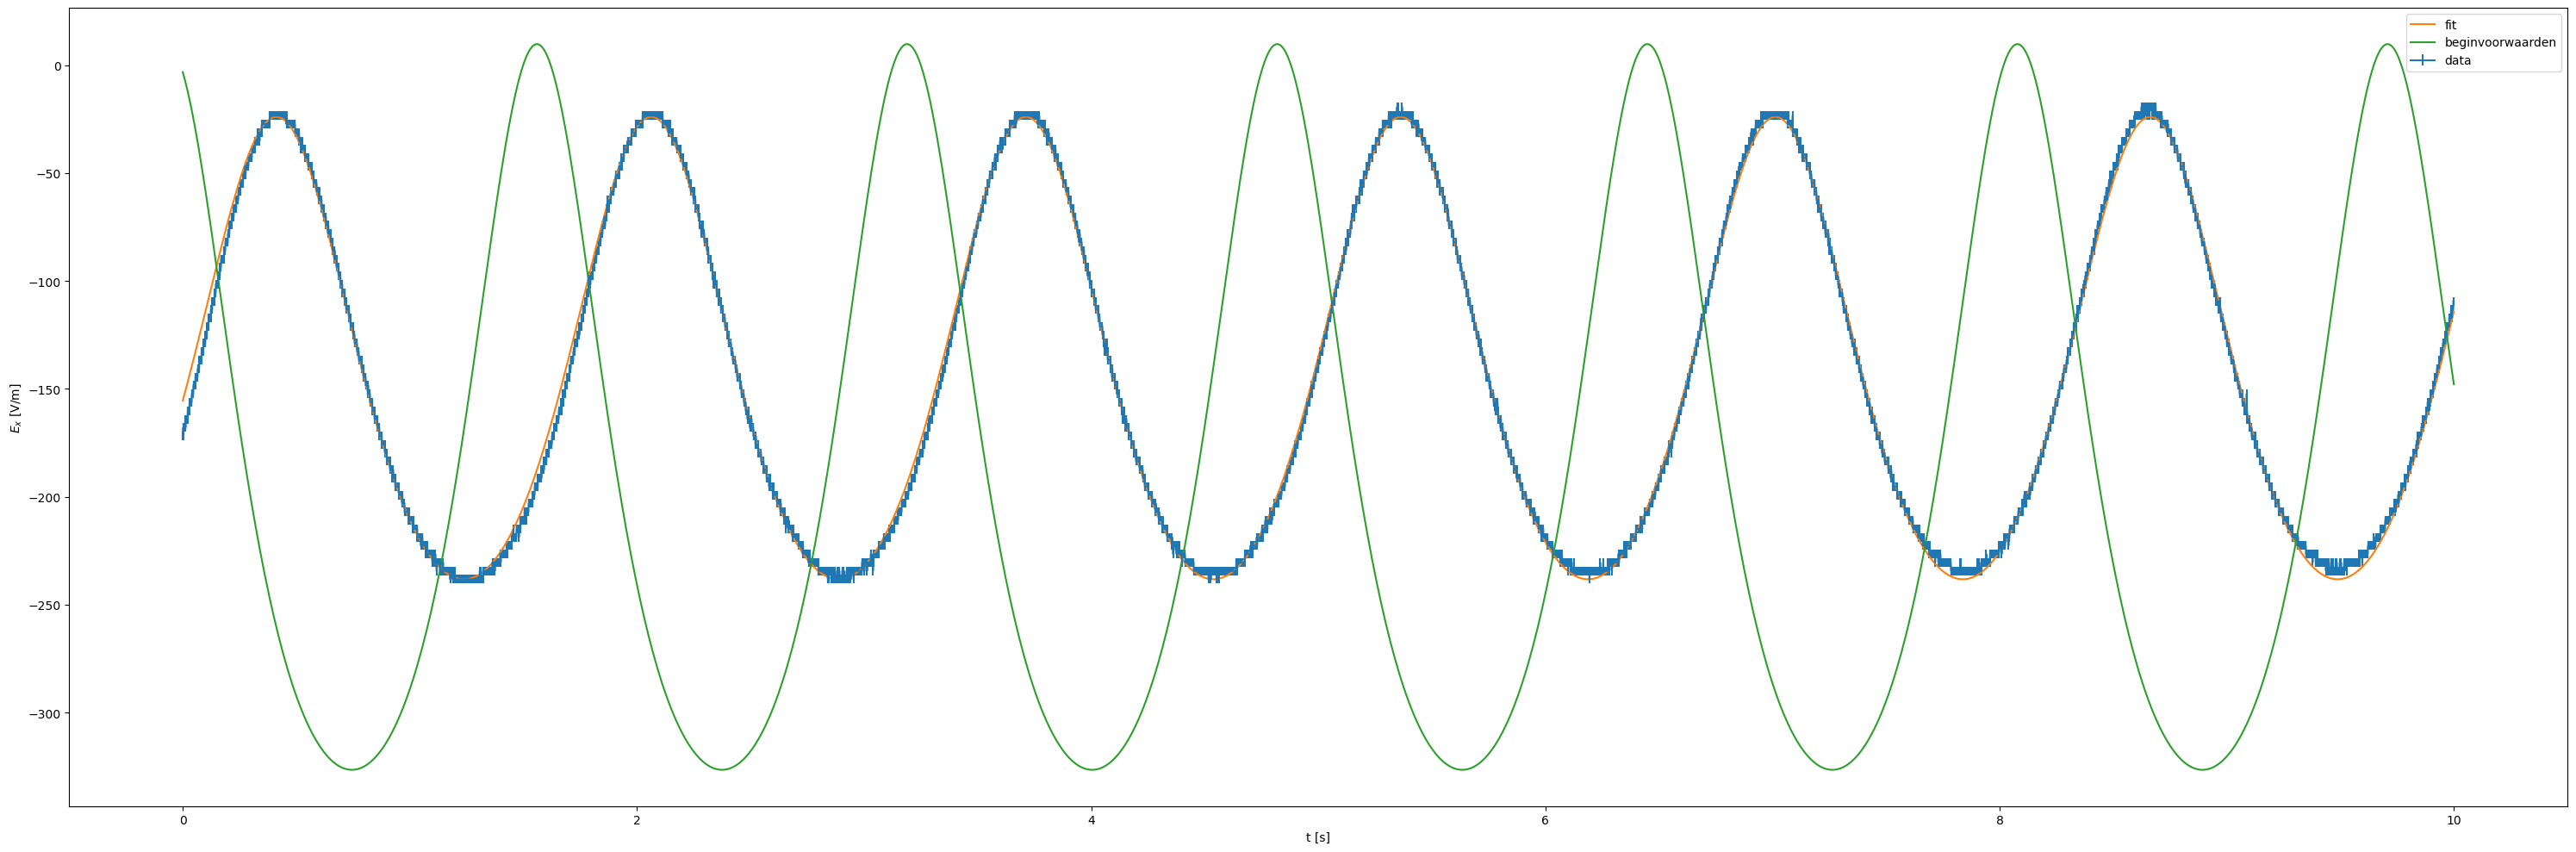

In [3]:
def analyseer_data(pad, x0, Kordelänge, q, method = '1D quasistatic', show_beginvoorwaarden = False, knipvanaf = 0, beginvoorwaarden = None):
    #de data-analyse voor de proef nummer 1
    
    def model_proef(Zeit, params):
        return model_E(Zeit, [Kordelänge, method], params)

    #extraheer data
    file = open(pad, 'rt')
    T, V, eenheid, invals = X_tractor(file.read()) #ACHTUNG: Spannung aus Millivolt
    V_err = np.full(np.shape(V), 20) #Ein Error von zwanzig Millivolt
    T, V, V_err = uncook_data(T, V, V_err)
    E = V/10 #E in V/m (want *100 voor V -> V/m en /1000 voor mV -> V)
    E_err = V_err/10
    file.close()
    if not knipvanaf == 0: #knip vanaf een bepaalde timestamp
        n0 = int(knipvanaf/(T[1] - T[0]))
        T = T[n0:]
        E = E[n0:]
        E_err = E_err[n0:]


    #beginvoorwaarden
    #die gemessen Parametern
    g = 9.81
    omega = np.sqrt(g/Kordelänge)
    print(omega, 'omega_inval')
    #fast fourrier transform voor wat beginvoorwaarden
    frequentielijst = np.fft.fft(E)
    modulus = np.abs(frequentielijst)
    C_0 = np.real(frequentielijst[0])*(T[1] - T[0]) # tes kaduk eh
    print('C_0 by fft', C_0)
    eigenfreq = np.argmax(modulus[1:]) #ça ne marche pas donc on ne l'utilise pas; il faut que ça soit 50Hz, parce que la prise existe, donc jsp mais il faut multiplier par 10
    print(eigenfreq)
    C_0 = -500

    if beginvoorwaarden is None:
        beginvoorwaarden = [-1.3, .15, C_0, omega, q, x0]

    def beginvwd(x,y):
        #1D, m1-1: 
        C_0 = -500
        return beginvoorwaarden
        #2D, m1-1: #fix
        #return [0, .3, C_0, omega, q, 0.35]



    #fit het boeltje
    outp = functies.fit(['phi', 'A', 'C_0', 'omega', 'q', 'x0'], model_proef, beginvwd, T, E, E_err, 
                        detailed_logs=False, bounds = [(-np.pi, np.pi), (0,0.5), (C_0-10, C_0+10), (omega*3/4, omega*5/4), (1e-10, 1e-7), (0.1, 0.7)],
                        minimizemethod = 'Nelder-Mead', fuck_mijn_pc=False )
    #, bounds = [(-np.pi, np.pi), (0,0.5), (C_0-10, C_0+10), (omega*3/4, omega*5/4), (1e-10, 1e-8), (0.1, 0.4)] gebruik ze of niet
    print(outp)
    fitparams = [param[0] for param in outp]





    ##het boeltje plotten
    fig, ax = plt.subplots(1,1, figsize = (30,10))
    ax.errorbar(T, E, yerr = E_err, label = 'data', fmt = '')
    Zeitlinspace = np.linspace(knipvanaf,10,1000)
    ax.plot(Zeitlinspace, model_proef(Zeitlinspace, fitparams), label = 'fit')
    if show_beginvoorwaarden:
        ax.plot(Zeitlinspace, model_proef(Zeitlinspace, beginvwd(0,0)), label = 'beginvoorwaarden')
    ax.set_ylabel('$E_x$ [V/m]')
    ax.set_xlabel('t [s]')
    #ax.set_xlim(0,4) #esthetische parameter
    ax.legend()
    plt.tight_layout()
    plt.show()

3.8553386833890952 omega_inval
C_0 by fft 728.3984375000005
4


c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[[1.006662707933438, 1.0075493550651682], [0.06658254110580192, 0.06662437048001153], [-191.1870915605154, -191.29853986382415], [1.7354342886800387, 7.122161299289518], [1.331239821444386e-09, 1.3317415261097714e-09], [0.2250708364358893, 0.22507083643709735]]
phi heeft als waarde: 1.0071 + 0.00044334 - 0.00044331 met 68% betrouwbaarheidsinterval: [1.0067, 1.0075] 
A heeft als waarde: 0.066603 + 2.0911e-05 - 2.0918e-05 met 68% betrouwbaarheidsinterval: [0.066583, 0.066624] 
C_0 heeft als waarde: -191.24 + -0.055722 - -0.055726 met 68% betrouwbaarheidsinterval: [-191.19, -191.3] 
omega heeft als waarde: 3.8081 + 3.3141 - 2.0726 met 68% betrouwbaarheidsinterval: [1.7354, 7.1222] 
q heeft als waarde: 1.3315e-09 + 2.5086e-13 - 2.5085e-13 met 68% betrouwbaarheidsinterval: [1.3312e-09, 1.3317e-09] 
x0 heeft als waarde: 0.22509 + -1.7065e-05 - 1.7065e-05 met 68% betrouwbaarheidsinterval: [0.22507, 0.22507] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De 

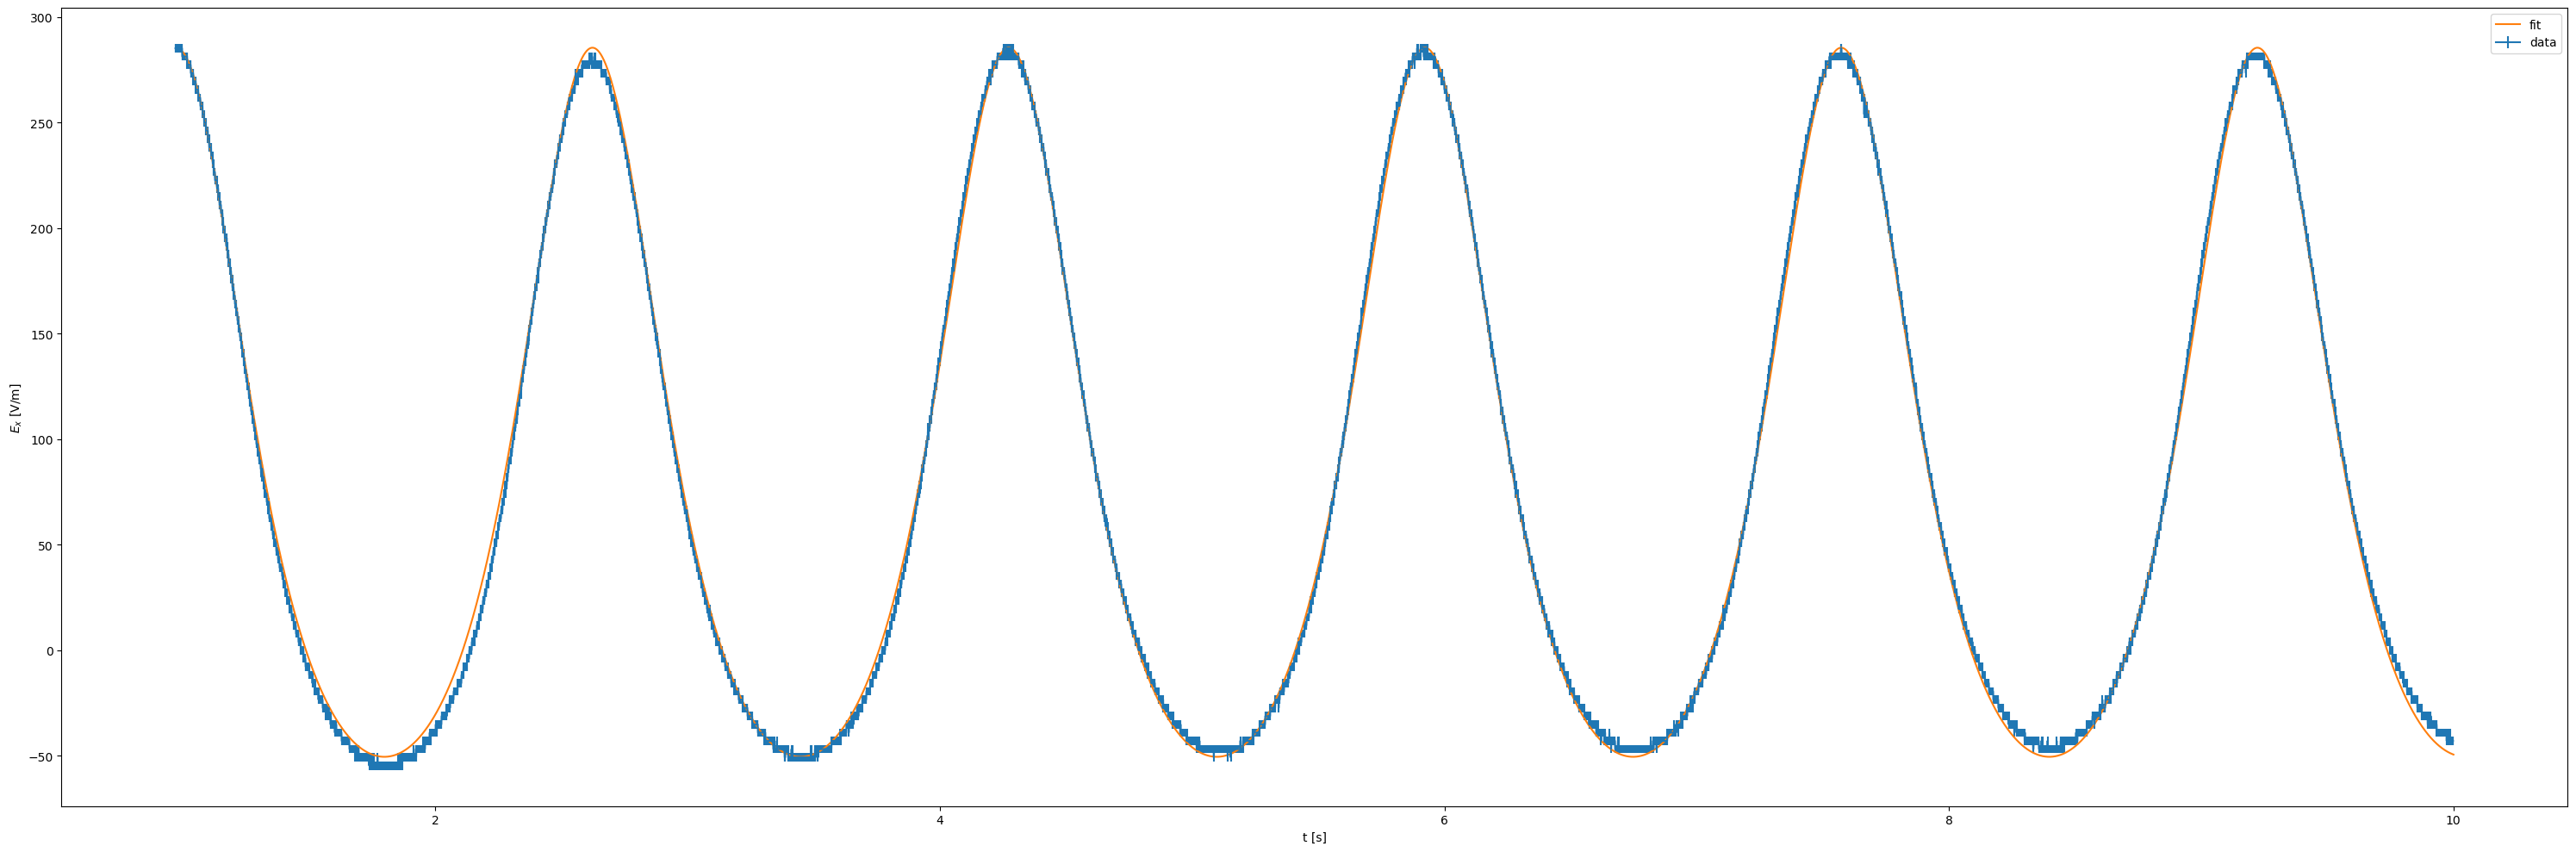

[1.0071060143841224, 0.06660345939921775, -191.24281782359674, 3.808082494107852, 1.331490666554091e-09, 0.22508790124502898]


In [12]:
#de data-analyse voor de proef nummer 2
pad = 'Vrije proef/m2-2.txt'
def model_proef_1(Zeit, params):
    return model_E(Zeit, [0.66, '1D quasistatic'], params)


file = open(pad, 'rt')

T, V, eenheid, invals = X_tractor(file.read()) #ACHTUNG: Spannung aus Millivolt
if pad == 'Vrije proef/m2-1.txt': #bij deze is er een vreemde eerste oscillatie dus die knippen we weg
    n0 = int(1.5/(T[1] - T[0])) #de n voor 1.5s
    T = T[n0:]
    V = V[n0:]
elif pad == "Vrije proef/m2-2.txt":
    start_indx = 970 #m2-2 begint voor de een of andere reden met van -1300 naar 2000 stijgen, dus dat ff wegknippen lol
    T = T[start_indx:]
    V = V[start_indx:]
V_err = np.full(np.shape(V), 20) #Ein Error von zwanzig Millivolt
T, V, V_err = uncook_data(T, V, V_err)

E = V/10 #E in V/m (want *100 voor V -> V/m en /1000 voor mV -> V)
E_err = V_err/10
file.close()

#die gemessen Parametern
Kordelänge = 66.0e-2
g = 9.81
omega = np.sqrt(g/Kordelänge)
print(omega, 'omega_inval')
q = 3e-9 #Coulomb

#fast fourrier transform voor wat beginvoorwaarden
frequentielijst = np.fft.fft(E)
modulus = np.abs(frequentielijst)
C_0 = np.real(frequentielijst[0])*(T[1] - T[0]) # tes kaduk eh
print('C_0 by fft', C_0)
eigenfreq = np.argmax(modulus[1:]) #ça ne marche pas donc on ne l'utilise pas; il faut que ça soit 50Hz, parce que la prise existe, donc jsp mais il faut multiplier par 10
print(eigenfreq)
C_0 = -50
def beginvwd(x,y):
    #1D, m1-1: 
    C_0 = -50
    return [np.pi/2, 0.05, C_0, omega, 1e-8, 0.66]

    #Oude dingen, bijgehouden om niet weg te gooien
    #C_0 = -500
    #return [-1.3, .15, C_0, omega, q, 0.57]
    #2D, m1-1: #fix
    #return [0, .3, C_0, omega, q, 0.35]

outp = functies.fit(['phi', 'A', 'C_0', 'omega', 'q', 'x0'], model_proef_1, beginvwd, T, E, E_err, 
                     detailed_logs=False, bounds = [(-np.pi, np.pi), (0,0.5), (C_0-1000, C_0+1000), (omega*3/4, omega*5/4), (1e-10, 2e-8), (0.1, 0.7)],
                    minimizemethod = 'Nelder-Mead', fuck_mijn_pc=False )
#, bounds = [(-np.pi, np.pi), (0,0.5), (C_0-10, C_0+10), (omega*3/4, omega*5/4), (1e-10, 1e-8), (0.1, 0.4)] gebruik ze of niet
print(outp)
fitparams = [param[0] for param in outp]
fig, ax = plt.subplots(1,1, figsize = (30,10))
ax.errorbar(T, E, yerr = E_err, label = 'data', fmt = '')
if pad == 'Vrije proef/m2-1.txt':
    Zeitlinspace = np.linspace(1.5,10,1000)
elif pad == "Vrije proef/m2-2.txt":
    Zeitlinspace = np.linspace(1, 10, 10000)
else:
    Zeitlinspace = np.linspace(0,10,1000)
ax.plot(Zeitlinspace, model_proef_1(Zeitlinspace, fitparams), label = 'fit')
#ax.plot(Zeitlinspace, model_proef_1(Zeitlinspace, beginvwd(0,0)), label = 'beginvoorwaarden')
ax.set_ylabel('$E_x$ [V/m]')
ax.set_xlabel('t [s]')
#ax.set_xlim(0,4) #esthetische parameter
ax.legend()
plt.tight_layout()
plt.show()
print(fitparams)